In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pdb
import math
import random

In [2]:
import torch
torch.cuda.is_available()

False

# VAE architecture for regression - Conditional VAE
Architecture refinement according to **Tutorial on variatonal autoencoders** https://arxiv.org/pdf/1606.05908.pdf?ref=https://githubhelp.com

Probabilistic regression problem. Given input $x$, we want to sample from $P(y|x)$
## Generative model for marginal probability
Representation through latent variable $z$:
$$P(y) = \int P(y|z) P(z)dz$$
### Maximum likelihood approach
Introduce approximate inverse for $P(y|z)$. Let it be $Q(z|y)$.
And minimize approximation error:
$$ D(Q(z|y)~ ||~ P(z|y)) = \mathbb{E}_{z \sim Q(z|y)} \left( \log Q(z|y) - \log P(z|y) \right)$$
Applying Bayes theorem:
$$\log P(z|y) = \log \left[ \frac{P(y|z) P (z)}{P(y)} \right] = \log P(y|z) + \log P(z) - \log P(y)$$
Rearranging terms:
$$ \underbrace{\log P(y)}_{\text{exact likelihood}} - \underbrace{D(Q(z|y) ~ ||~  P(z|y))}_{\text{approximation error}} = \underbrace{\overbrace{\mathbb{E}_{z \sim Q(z|y)} \log P(y|z)}^{\text{reconstruction}} - \overbrace{D(Q(z|y)~ ||~ P(z) )}^{\text{regulartization}}}_{\text{Evidence Lower Bound (ELBO)}}$$

Optimizing **ELBO**, we 
- Increase likelihood for a given data point
- Reduce approximation error of encoder

## Generative model for conditional probability
Modify data generating formula by formally introducing conditioning:
$$ P(y|x) = \int P(y|z,x) P(z|x) dz $$
**Later modeling assumption will be applied**:
$$ P(z|x) \equiv P(z)$$
Formally, introduce conditioning on each formula above:
$$ \underbrace{\log P(y|x)}_{\text{exact likelihood}} - \underbrace{D(Q(z|y,x) ~ ||~  P(z|y,x))}_{\text{approximation error}} = \underbrace{\overbrace{\mathbb{E}_{z \sim Q(z|y,x)} \log P(y|z,x)}^{\text{reconstruction}} - \overbrace{D(Q(z|y,x)~ ||~ P(z) )}^{\text{regulartization}}}_{\text{Evidence Lower Bound (ELBO)}}$$
### Structure of ELBO requires the following architecture of Conditional VAE
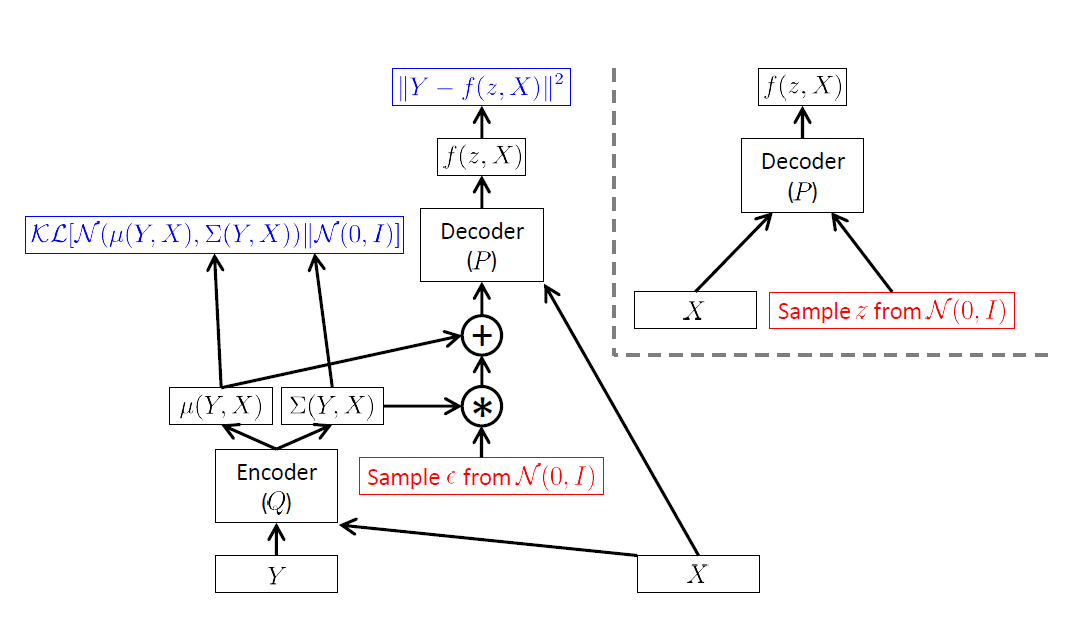

# Architecture of encoder, decoder, latent space and loss function
## Ecnoder
- Covariance matrix of encoder $\Sigma(y,x)$ is diagonal
- Parameterization of variance channel - log variance: $$\sigma^2=\exp(\lambda) $$ ["Pytorch examples", Rybkin2021 uses logstd instead]

## Decoder
- Decoder has Gaussian likelihood with **fixed** variance: $$\Sigma(x,z) = I \sigma^2$$
- Variance of decoder is estimated at each batch as max-likelihood at fixed mean channel [Rybkin2021]:
$$ \sigma^2 = \text{arg max}_{\sigma^2}\mathcal{N} (y| x,z) = MSE$$
- Variance of decoder is not used for data generation, as in many practical examples $\sigma \to 0$ [Bin Dai 2019]

## Loss function
- For correct estimation of **ELBO**, loss function should be **summed** over output channels of decoder 
and output channels of encoder [Rybkin2021]:
$$ Loss = \frac{D}{2}\ln 2 \pi + D \ln \sigma + \frac{D}{2 \sigma^2} MSE(y,f(z,x))+D_{KL}(q(z|x,y) || p(z)) $$
$ D $ - number of output channels of decoder

## Latent space
According to [Diagnosing and Enhancing VAE Models, Bin Dai 2019]: 
- the number of latent variables ($\kappa$) should be larger
than the number of dimensions of manifold ($r$) data belongs to:
$$ \kappa \geq r $$
- The best performance VAE shows when $r$ is equal to the dimensionality of space $y \in \mathcal{R}^n$:
$$ r = n $$
i.e. when probability density can be introduced for data points

# Proposed architecture for VAE of subgrid forcing
## Decoder architecture is only slightly different from Andrew's CNN
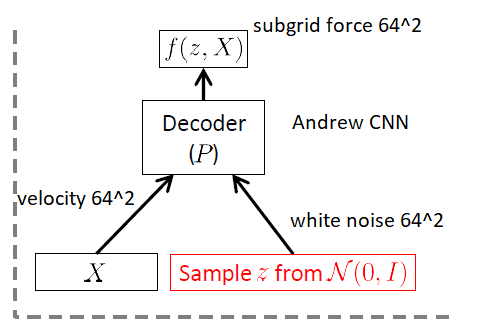

# Learning metrics
- MSE should be less than best regression prediction
- Variance channel for z averaged. Typical values before convergence ~ 1, after ~0
- Agregated posterior variance:
$$ P(z)=Q(z|x,y)P(x,y)=\mathcal{N}(\mu(x,y), \sigma^2(x,y))P(x,y) $$
$$ z(x,y) = \mu(x,y) + \sigma(x,y) \epsilon $$
$$ mean(z) = \int \mu(x,y) + \sigma(x,y) \epsilon   P(x,y) P(\epsilon) dxdy d\epsilon =
\langle \mu \rangle_{x,y}$$
$$ mean(z^2) = \int (\mu(x,y) + \sigma(x,y) \epsilon)^2   P(x,y) P(\epsilon) dxdy d\epsilon =
\langle \mu^2 \rangle_{x,y} + \langle \sigma^2 \rangle_{x,y}$$

In [44]:
Npoints = 100000
x = torch.rand(Npoints,1).sort(dim=0)[0]

In [45]:
def mean_curve(x):
    return torch.sin(10*x)
def std_curve(x, par):
    return torch.sqrt(var_curve(x, par))
def var_curve(x, par):
    return par * par * torch.abs(torch.cos(10*x))
def confidence_95(x, par):
    return torch.column_stack([mean_curve(x)+1.96*std_curve(x,par), mean_curve(x)-1.96*std_curve(x,par)])
def generate_noise(x, par):
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    
    eps1 = torch.randn(Npoints,1)+2
    eps2 = torch.randn(Npoints,1)-2
    eps3 = (torch.rand(Npoints,1)>0.5).int()
    eps4 = 1 - eps3
    
    eps = (eps1*eps3+eps2*eps4) / np.sqrt(5)
    #eps = torch.randn(Npoints,1)
    return std_curve(x,par) * eps
def generate_data(x, par):
    return mean_curve(x) + generate_noise(x, par)
def MSE_min(x, par):
    return var_curve(x,par).mean()
def Gauss_min(x, par):
    return 0.5 + 0.5 * torch.log(var_curve(x,par)).mean()

In [46]:
pars = [0.01, 1]

In [47]:
for par in pars:
    print(f'data var = {generate_data(x,par).var()},MSE min = {MSE_min(x,par)}, Gauss min = {Gauss_min(x,par)}')

data var = 0.4417300522327423,MSE min = 6.551033584401011e-05, Gauss min = -4.4334516525268555
data var = 1.100238561630249,MSE min = 0.6551033854484558, Gauss min = 0.1717182695865631


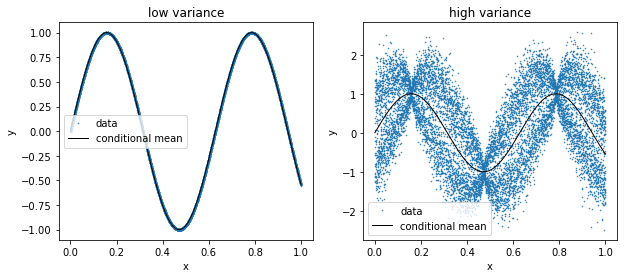

In [50]:
def plot_data(x,par,title):
    y = generate_data(x,par)
    plt.plot(x[0:-1:10],y[0:-1:10],'.',markersize=1)
    plt.plot(x,mean_curve(x),'k-',linewidth=1)
    #plt.plot(x,confidence_95(x,par),'k--',linewidth=1)
    plt.legend(['data', 'conditional mean', '95% confidence interval'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)

fig = plt.figure(figsize=(10,4))
plt.subplot(121)
plot_data(x,pars[0],title='low variance')
plt.subplot(122)
plot_data(x,pars[1],title='high variance')

In [206]:
# Encoder inputs: x, y
# Encoder outputs: mean, logstd channels
# Decoder inputs: x, z
# Decoder outputs: only mean channel

class Net(nn.Module):
    def __init__(self, width, depth, ANN_type='MSE'):
        super().__init__()
        
        blocks_encoder = []
        blocks_encoder.extend([nn.Linear(2,width), nn.ReLU(), nn.BatchNorm1d(width)])
        for j in range(depth-2):
            blocks_encoder.extend([nn.Linear(width,width), nn.ReLU(), nn.BatchNorm1d(width)])
        
        blocks_encoder.append(nn.Linear(width,2))
        
        self.encoder_net = nn.Sequential(*blocks_encoder)
        
        blocks_decoder = []
        blocks_decoder.extend([nn.Linear(2,width), nn.ReLU(), nn.BatchNorm1d(width)])
        for j in range(depth-2):
            blocks_decoder.extend([nn.Linear(width,width), nn.ReLU(), nn.BatchNorm1d(width)])
        
        blocks_decoder.append(nn.Linear(width,1))
        
        self.decoder_net = nn.Sequential(*blocks_decoder)
    
    def forward(self, x, y):
        encoder_out = self.encoder_net(torch.cat((x, y), dim=1))
        mean = encoder_out[:,0:1]
        var = nn.functional.softplus(encoder_out[:,1:2])
        
        #logvar = encoder_out[:,1:2]
        #var = torch.exp(logvar)
        
        std = torch.sqrt(var)
        
        z = mean + std * torch.randn_like(std)
        
        yhat = self.decoder_net(torch.cat((x, z), dim=1))
        
        return yhat, mean, var
    def generate_data(self, x):
        with torch.no_grad():
            z = torch.randn_like(x)
            y = self.decoder_net(torch.cat((x, z), dim=1))
            return y
    def sample_mean_var(self, x, n):
        with torch.no_grad():
            y = torch.zeros(n,x.shape[0],x.shape[1])
            for i in range(n):
                z = torch.randn_like(x)
                y[i,:,:] = self.decoder_net(torch.cat((x, z), dim=1))
            return y.mean(dim=0), y.var(dim=0)

In [207]:
def minibatch(net, x, y, batch_size=64):
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    batches = x.shape[0] // batch_size
    if (batches * batch_size < x.shape[0]):
        batches += 1
    for batch in range(batches):
        idxx = idx[batch*batch_size:(batch+1)*batch_size]
        xx = x[idxx]
        yy = y[idxx]
        yield xx,yy

In [244]:
def criterion(yhat, mean, var, ytrue, regularize = 0):
    # KL batch-wise and channel-wise
    KL_pointwise = 0.5*((var + torch.square(mean)) - torch.log(var) - 1)
    # KL batch-averaged and channel-summed
    # DD - number of latent variables
    DD = 1
    loss_KL = DD * KL_pointwise.mean()
    
    # sigma - "precision" of decoder    
    # sigma - MSE for each output channel
    Squared_error = torch.square(yhat - ytrue)
    sigma_sq = Squared_error.mean().item()
    logsigma = 0.5 * np.log(sigma_sq)
    
    # D - number of output channels
    D = 1
    loss_Gauss = D * (0.5 * np.log(2*np.pi) + logsigma + Squared_error.mean() / (2 * sigma_sq))
    
    loss = loss_KL + loss_Gauss
    
    if regularize > 0:
        denominator = mean.pow(2).mean() - mean.mean().pow(2)
        numerator = var.mean()
        loss += regularize * numerator / denominator        
    
    n = yhat.shape[0]
    
    return loss, n, Squared_error.mean()

In [245]:
def train(net, x, y, lr=0.001, num_epochs=100, batch_size=64, regularize = 0):    
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)
    
    net.loss_history = {'VAE': [], 'mse': [], 'var_channel': [], 'aggregated_posterior': []}
    
    for epoch in range(num_epochs):
        epoch_loss = 0.
        epoch_mse = 0.
        epoch_n = 0
        for xx, yy in minibatch(net, x, y, batch_size):
            optimizer.zero_grad()
            yhat, mean, var = net.forward(xx, yy)
            loss, nb, loss_mse = criterion(yhat, mean, var, yy, regularize)
            loss.backward()
            optimizer.step()
            
            epoch_loss += nb * loss.item()
            epoch_mse += nb * loss_mse.item()
            epoch_n += nb
        
        aggregated_posterior = var.mean() + mean.pow(2).mean() - mean.mean().pow(2)
        net.loss_history['VAE'].append(epoch_loss/epoch_n)
        net.loss_history['mse'].append(epoch_mse/epoch_n)
        net.loss_history['var_channel'].append(var.mean().item())
        net.loss_history['aggregated_posterior'].append(aggregated_posterior.item())
        
        scheduler.step()
        if epoch % 10 == 0:
            print(f"epoch = {epoch+1}, numpoints = {epoch_n}, VAE LOSS = {epoch_loss/epoch_n}, MSE = {epoch_mse/epoch_n}, var = {var.mean().item()}, posterior = {aggregated_posterior}")

In [246]:
net = Net(100,1); par = pars[1]

In [247]:
train(net, x, generate_data(x,par), lr = 0.001, num_epochs=1000, batch_size=10000, regularize = 0.)

epoch = 1, numpoints = 100000, VAE LOSS = 1.512447714805603, MSE = 1.064333862066269, var = 0.7543430328369141, posterior = 0.8193934559822083
epoch = 11, numpoints = 100000, VAE LOSS = 1.3590619444847107, MSE = 0.6914740264415741, var = 0.7671537399291992, posterior = 0.9749166965484619
epoch = 21, numpoints = 100000, VAE LOSS = 1.3063096880912781, MSE = 0.6899630069732666, var = 0.8695412874221802, posterior = 0.985116183757782
epoch = 31, numpoints = 100000, VAE LOSS = 1.2797294855117798, MSE = 0.7039721488952637, var = 0.9342864155769348, posterior = 1.0022026300430298
epoch = 41, numpoints = 100000, VAE LOSS = 1.2319363355636597, MSE = 0.6650453984737397, var = 0.9691263437271118, posterior = 0.9956485033035278
epoch = 51, numpoints = 100000, VAE LOSS = 1.2159103512763978, MSE = 0.6618308067321778, var = 0.9963302612304688, posterior = 1.0033819675445557
epoch = 61, numpoints = 100000, VAE LOSS = 1.2132885217666627, MSE = 0.6614307463169098, var = 0.9960182905197144, posterior = 0

epoch = 561, numpoints = 100000, VAE LOSS = 1.1244103550910949, MSE = 0.14268531650304794, var = 0.26193496584892273, posterior = 0.972501814365387
epoch = 571, numpoints = 100000, VAE LOSS = 1.1228160858154297, MSE = 0.1419942259788513, var = 0.2611371576786041, posterior = 0.9737570881843567
epoch = 581, numpoints = 100000, VAE LOSS = 1.126878809928894, MSE = 0.1434064418077469, var = 0.26089993119239807, posterior = 0.9701582193374634
epoch = 591, numpoints = 100000, VAE LOSS = 1.1234015822410583, MSE = 0.14048200249671935, var = 0.2596679925918579, posterior = 0.9884305000305176
epoch = 601, numpoints = 100000, VAE LOSS = 1.1220256447792054, MSE = 0.13917333334684373, var = 0.25786617398262024, posterior = 0.9769775867462158
epoch = 611, numpoints = 100000, VAE LOSS = 1.1215750694274902, MSE = 0.1377817139029503, var = 0.2555866241455078, posterior = 0.9849778413772583
epoch = 621, numpoints = 100000, VAE LOSS = 1.1255491852760315, MSE = 0.13976314961910247, var = 0.256113231182098

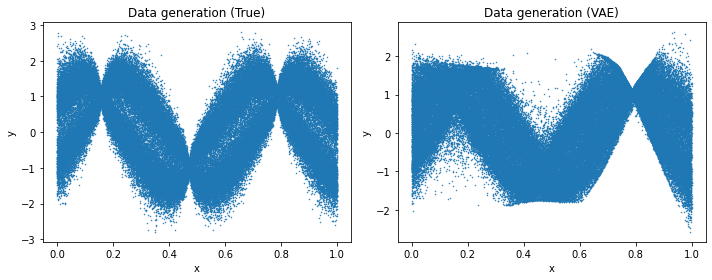

In [248]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(x,generate_data(x,par),'.', markersize = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data generation (True)')
plt.subplot(122)
plt.plot(x,net.generate_data(x),'.', markersize = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data generation (VAE)')
plt.tight_layout()

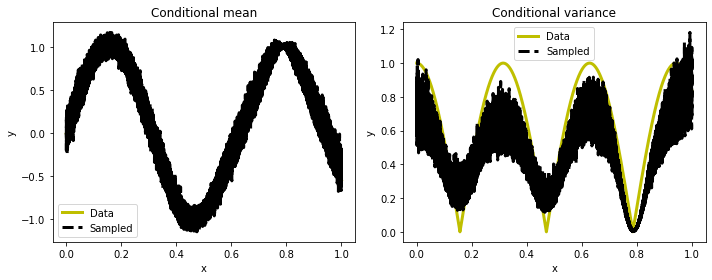

In [249]:
m, v = net.sample_mean_var(x,100)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(x,mean_curve(x),'y-',linewidth=3)
plt.plot(x,m,'k--',linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Conditional mean')
plt.legend(('Data', 'Sampled'))
plt.subplot(122)
plt.plot(x,var_curve(x,par),'y-',linewidth=3)
plt.plot(x,v,'k--',linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Conditional variance')
plt.legend(('Data', 'Sampled'))
plt.tight_layout()

Text(0.5, 1.0, 'Marginal PDF ANN')

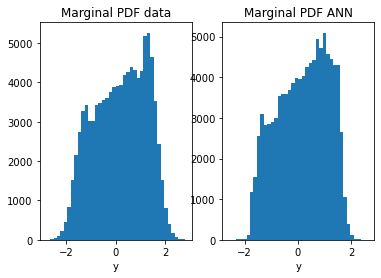

In [250]:
plt.subplot(121)
y = np.array(generate_data(x, par))
plt.hist(y,40);
plt.xlabel('y')
plt.title('Marginal PDF data')
plt.subplot(122)
yy = np.array(net.generate_data(x))
plt.hist(yy,40);
plt.xlabel('y')
plt.title('Marginal PDF ANN')

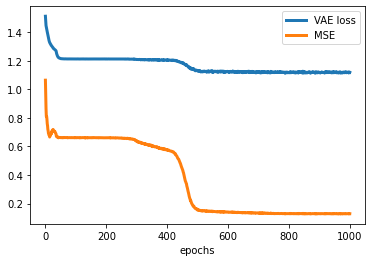

In [251]:
plt.plot(net.loss_history['VAE'], linewidth=3)
plt.plot(net.loss_history['mse'], linewidth=3)
plt.xlabel('epochs')
plt.legend(('VAE loss', 'MSE'))

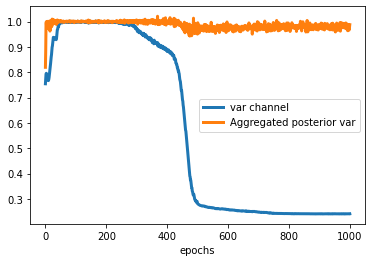

In [252]:
plt.plot(net.loss_history['var_channel'], linewidth=3)
plt.plot(net.loss_history['aggregated_posterior'], linewidth=3)
plt.xlabel('epochs')
plt.legend(('var channel', 'Aggregated posterior var'))

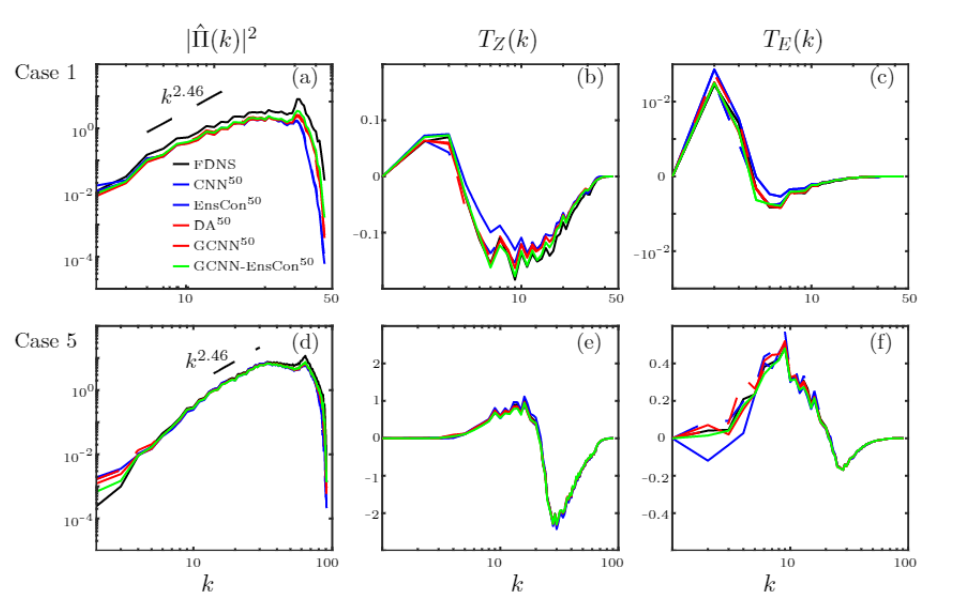

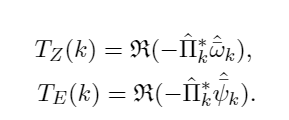